# Projeto 1 - Ciência dos Dados

Nome: Enzo Davi

Nome: Antonio Anderson

Nome: Felipe Leventhal

Atenção: Serão permitidos grupos de três pessoas, mas com uma rubrica mais exigente. Grupos deste tamanho precisarão fazer um questionário de avaliação de trabalho em equipe

___
Carregando algumas bibliotecas:

In [2]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import re
import unidecode
import nltk
from nltk import SnowballStemmer
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split

In [3]:
print('Esperamos trabalhar no diretório')
print(os.getcwd())

Esperamos trabalhar no diretório
C:\Users\enzod\Downloads\CDADOS\PROJETO 1


Carregando a base de dados com os tweets classificados manualmente:

In [4]:
train = pd.read_excel('dados_treino1.xlsx')

In [5]:
test = pd.read_excel('dados_teste1.xlsx')

___
## Classificador automático


Nosso modelo estuda uma base de dados que contém críticas a livros presentes na plataforma da Amazon. Sendo assim, nossa classificação tem como base 4 grupos: 
* Grupo 1: Comentários voltados para o conteúdo do livro.
* Grupo 2: Comentários do livro que contenham sentimento.
* Grupo 3: Comentários que envolvem a *Amazon* do livro.
* Grupo 4: Comentários que envolvem a *Editora* do livro.

In [6]:
train.head(3)

,Mensagem,TARGET
0,A caixa do box veio rasgada e amaçada; página ...,3
1,"A caixa veio estragada, queria deixar ela a mo...",3
2,A caixa veio rasgada e os livros parecem usados,3


In [7]:
test.head(3)

,Mensagem,TARGET
0,"A história em si é boa, mas é bem cansativa. T...",1
1,"Muito difícil a leitura deste livro, acredito ...",1
2,Poemas curtos e muito rasos. Pensei que encont...,1


In [8]:
train.TARGET.value_counts().sort_index()

1     99
2    204
3    118
4     79
Name: TARGET, dtype: int64

In [9]:
test.TARGET.value_counts().sort_index()

1     50
2    115
3     62
4     23
Name: TARGET, dtype: int64

# Preparando os dados:

Antes de partimos para a classificação, é necessário um tratamento dos dados para um melhor aproveitamento e facilitação das etapas futuras.

## Limpeza dos dados

In [10]:
def cleanup(text):
    
    #Remove as pontuações
    pontuacao = '[´"!-.:1234567890?;$/'']' 
    pattern = re.compile(pontuacao)
    texto_limpo = re.sub(pattern, '', text)
    
    #Remove acentos
    texto_limpo = unidecode.unidecode(texto_limpo)
    return texto_limpo        

In [11]:
def tokenize(texto):
    # Deixa todas as letras minúsculas
    texto = texto.lower()
    palavras = texto.split()

    # Crie uma lista para armazenar os bigramas
    bigramas = []

    # Use um loop para criar bigramas a partir da lista de palavras
    for i in range(len(palavras) - 1):
        bigrama = palavras[i] + " " + palavras[i + 1]
        bigramas.append(bigrama)

    return bigramas


In [12]:
nltk.download('stopwords')
stop_words = nltk.corpus.stopwords.words('portuguese')
stop_words.append('')
stop_words = list(stop_words)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\enzod\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [13]:
#Retira as palavras que são irrelevantes (Não contém informações)
def stop_word(lista_texto):   
    new_list = list()
    for palavra in lista_texto:
        if palavra not in stop_words:
            new_list.append(palavra)

    return new_list

In [14]:
#Absorve apenas a raiz de cada palavra 
def stemming(lista_texto):
    stemmer = SnowballStemmer('portuguese')
    new_list = list()
    for palavra in lista_texto:
        new_list.append(stemmer.stem(palavra))
    
    return new_list

In [15]:
#Transforma o df em string
def to_text(data):
    texto = ''
    for frase in data.Mensagem:
        texto += frase + " " 
    return texto

In [16]:
# Roda todas as funções de limpeza para um df
def run(texto):
    texto = to_text(texto)
    texto = cleanup(texto)
    texto = tokenize(texto)
    texto = stop_word(texto)
    texto = stemming(texto)
    series_texto = pd.Series(texto, dtype='object')
    return series_texto

In [17]:
# Roda todas as funções de limpeza para uma string
def run2(texto):
    texto = cleanup(texto)
    texto = tokenize(texto)
    texto = stop_word(texto)
    texto = stemming(texto)
    series_texto = pd.Series(texto, dtype='object')
    return series_texto

## Classificando os grupos:


* Primeiro, o modelo precisa ser treinado usando um conjunto de dados rotulados. No nosso caso, o conjunto de dados consiste em críticas de livros agrupadas em quatro categorias: Grupo 1, Grupo 2, Grupo 3 e Grupo 4.


In [18]:
Grupo1 = train.loc[train.TARGET == 1, :]

Grupo2 = train.loc[train.TARGET == 2, :]

Grupo3 = train.loc[train.TARGET == 3, :]

Grupo4 = train.loc[train.TARGET == 4, :]

In [19]:
#Frequência relativa de cada Grupo
tabela_relativa_Grupo1 = run(Grupo1).value_counts(True)
tabela_relativa_Grupo2 = run(Grupo2).value_counts(True)
tabela_relativa_Grupo3 = run(Grupo3).value_counts(True)
tabela_relativa_Grupo4 = run(Grupo4).value_counts(True)

In [20]:
#Frequência absoluta de cada Grupo
tabela_absoluta_Grupo1 = run(Grupo1).value_counts()
tabela_absoluta_Grupo2 = run(Grupo2).value_counts()
tabela_absoluta_Grupo3 = run(Grupo3).value_counts()
tabela_absoluta_Grupo4 = run(Grupo4).value_counts()

In [21]:
#Frequências da base de treino
tabela_train = run(train)
tabela_train_relativa = tabela_train.value_counts(True)
tabela_train_absoluta = tabela_train.value_counts()

In [22]:
#Treino sem repetição de palavras
tabela_train_sem_repetir = set(tabela_train)

* Probabilidades a Priori (Prior Probability): Para cada grupo (1, 2, 3 e 4), calculamos a probabilidade a priori, ou seja, a probabilidade de um comentário pertencer a cada um desses grupos. Isso é feito contando quantos comentários existem em cada grupo e dividindo pelo total de comentários.

$$P(Grupo1) = \frac{Número De Palavras Grupo1}{Número De Palavras Totais}$$

O processo é análogo para os outros grupos.


$$P(Grupo2) = \frac{Número De Palavras Grupo2}{Número De Palavras Totais}$$

$$P(Grupo3) = \frac{Numero De Palavras Grupo3}{Numero De Palavras Totais}$$

$$P(Grupo4) = \frac{Número De Palavras Grupo4}{Número De Palavras Totais}$$

In [49]:
probG1 = tabela_absoluta_Grupo1.sum()/tabela_train_absoluta.sum()
probG2 = tabela_absoluta_Grupo2.sum()/tabela_train_absoluta.sum()
probG3 = tabela_absoluta_Grupo3.sum()/tabela_train_absoluta.sum()
probG4 = tabela_absoluta_Grupo4.sum()/tabela_train_absoluta.sum()

* Probabilidades Condicionais (Likelihood): Para cada palavra (característica) no conjunto de dados, calculamos a probabilidade condicional de a palavra aparecer em um comentário de cada grupo. Essas probabilidades condicionais são calculadas separadamente para cada grupo.

$$P(Palavra|Grupo1) = \frac{P(Grupo1|Palavra) P(Palavra)}{P(Grupo1)}$$

O processo é análogo para os outros grupos.

 $$P(Palavra|Grupo2) = \frac{P(Grupo2|Palavra) P(Palavra)}{P(Grupo2)}$$


 $$P(Palavra|Grupo3) = \frac{P(Grupo3|Palavra) P(Palavra)}{P(Grupo3)}$$
 

 $$P(Palavra|Grupo4) = \frac{P(Grupo4|Palavra) P(Palavra)}{P(Grupo4)}$$
 
* Probabilidade a Posteriori (Posterior Probability): Usando o teorema de Bayes, combinamos as probabilidades a priori e as probabilidades condicionais para calcular a probabilidade a posteriori de o novo comentário pertencer a cada um dos quatro grupos.

Por exemplo, para um novo comentário, podemos calcular a probabilidade a posteriori de pertencer ao Grupo 1, ao Grupo 2, ao Grupo 3 e ao Grupo 4.

In [34]:
def calcula_prob(frase ,tabela_absoluta, tabela_train_sem_repetir, probG, alpha=0.05):
    
    prob_condicional = 1
    for palavra in frase:
        if palavra in tabela_absoluta:    
            #Suavização de Laplace
            p = (tabela_absoluta[palavra] + alpha)/ (tabela_absoluta.sum() + len(tabela_train_sem_repetir) * alpha) 
            prob_condicional *= p * probG
            
        else:
            #Suavização de Laplace
            q =(0 + alpha)/ (tabela_absoluta.sum() + len(tabela_train_sem_repetir) * alpha)
            prob_condicional *= q * probG
            
    return prob_condicional


### 2. Classificação de Novos Comentários:
Depois que o modelo é treinado, ele pode ser usado para classificar novos comentários em uma das quatro categorias com base nas probabilidades calculadas.


* Classificação: Finalmente, classificamos o novo comentário no grupo com a maior probabilidade a posteriori. O grupo com a probabilidade mais alta é considerado a categoria prevista para o comentário.

Por exemplo, se a probabilidade a posteriori mais alta for a do Grupo 2, o novo comentário seria classificado como pertencente ao Grupo 2, indicando que ele contém sentimentos relacionados ao livro

In [35]:
def classificador_de_frases(data):
    
    resultado = []

    for frase in data.Mensagem:
        
        frase = run2(frase) # Aplica a função run2 que limpa a frase

        aux = []
        probFrase_dado_G1 = 1 
        probFrase_dado_G2 = 1
        probFrase_dado_G3 = 1
        probFrase_dado_G4 = 1
        
        #Calculamos a probabilidade posteriori de cada frase para cada target
        probFrase_dado_G1 = calcula_prob(frase,tabela_absoluta_Grupo1,tabela_train_sem_repetir , probG1)
        probFrase_dado_G2 = calcula_prob(frase, tabela_absoluta_Grupo2,tabela_train_sem_repetir, probG2)
        probFrase_dado_G3 = calcula_prob(frase, tabela_absoluta_Grupo3, tabela_train_sem_repetir, probG3)
        probFrase_dado_G4 = calcula_prob(frase, tabela_absoluta_Grupo4,tabela_train_sem_repetir,  probG4) 
        
        #Verificamos o maior termo e adicionamos seu respectivo valor semântico na lista
        aux.append(probFrase_dado_G1)
        aux.append(probFrase_dado_G2)
        aux.append(probFrase_dado_G3)
        aux.append(probFrase_dado_G4)
        aux = sorted(aux, reverse=True)
        
        if aux[0] == probFrase_dado_G1:
            resultado.append(1)
        elif aux[0] == probFrase_dado_G3:
            resultado.append(3)
        elif aux[0] == probFrase_dado_G2:
            resultado.append(2)
        else:
            resultado.append(4)
            
        
    return resultado

___
## Verificando a performance do Classificador


In [36]:
lista_teste = classificador_de_frases(test)

In [40]:
test['Bot'] = lista_teste
verificacao = (pd.crosstab(test.TARGET, test.Bot).round(4))
verificacao

Bot,1,2,3,4
TARGET,,,,
1,43,7,0,0
2,64,48,2,1
3,18,2,37,5
4,11,4,2,6


In [41]:
accuracy = (verificacao[1][1] + verificacao[2][2]+ verificacao[3][3] + verificacao[4][4])/2.5
accuracy

53.6

In [42]:
verificacao = (pd.crosstab(test.TARGET, test.Bot, normalize='index').round(4))*100
verificacao

Bot,1,2,3,4
TARGET,,,,
1,86.00,14.00,0.00,0.00
2,55.65,41.74,1.74,0.87
3,29.03,3.23,59.68,8.06
4,47.83,17.39,8.70,26.09


### Conclusão 

#### A partir das informações obtidas, é possível inferir que:

O nosso classificador obteve 53,6% de acurácia, isto é, ele classifica 53,6% dos comentários corretamente. 
Também podemos observar que:

- Obtemos 86.00% de verdadeiros 1, isto é, 14,00% dos comentários classificados como Grupo 1 foram classificados erroneamente (falsos 1).
- Obtemos 44,35% de verdadeiros 2, isto é, 55,65% dos comentários classificados como Grupo 2 foram classificados erroneamente (falsos 2).
- Obtemos 59,68% de verdadeiros 3, isto é, 40,32% dos comentários classificados como Grupo 3 foram classificados erroneamente (falsos 3).
- Obtemos 43,48% de verdadeiros 4, isto é, 73,94% dos comentários classificados como Grupo 4 foram classificados erroneamente (falsos 4).

#### Por quê não usar o próprio classificador para gerar mais amostras de treinamento?


O classificador automático, como podemos notar, constrói uma interpretação dos dados com base nas restrições dos indicadores que emprega para categorizar as avaliações. Portanto, se o utilizássemos para categorizar e posteriormente para treinar o modelo, estaríamos essencialmente permitindo que o código se baseasse em sua própria interpretação, que já é limitada, o que poderia resultar em um reforço das suas próprias deficiências. Isso, por sua vez, levaria a uma análise mais tendenciosa em vez de uma análise mais precisa.

#### Diferentes cenários para o Naive Bayes:

* O classificador poderia classificar letras de músicas do Spotify, subdividindo a música em diferentes gêneros musicais, como: Músicas Românticas, Músicas Relaxantes, etc.


* Além disso, o Naive-Bayes poderia ser utilizado para gerar uma análise de sentimento de postagens nas redes socias, como (positivo, negativo, neutro).


* O Naive-Bayes também pode ser utilizado em sistemas de recomendação de uma empresa de serviços de streaming, como o Amazon Prime, onde o classificador poderá recomendar ao usuário o filme que ele deveria assisir de acordo com seus gostos pessoais. 

#### Possíveis melhorias para o classificador:

* Uma possível melhoria para o modelo, seria analisarmos a entropia presente em cada análise de probabilidade. Isso permitiria desconsiderar casos em que a entropia entre as probabilidades é alta, ou seja, as probabilidades são bem próximas, e isso prejudica a assertividade do classificador.


* Outra maneira de melhorar a qualidade do classificador, seria aumentar o tamanho da base de dados. Sendo assim, esse aumento amplia a zona de assertividade do modelo.


#### Sarcasmo em Naive Bayes:

In [51]:
frase = '"Ah, sim, esse livro é uma obra-prima da literatura... se você considerar uma obra-prima a capacidade de transformar o sono em uma experiência mágica!"'
frase = run2(frase) 
aux = []
probFrase_dado_G1 = 1 
probFrase_dado_G2 = 1
probFrase_dado_G3 = 1
probFrase_dado_G4 = 1

#Calculamos a probabilidade posteriori de cada frase para cada target
probFrase_dado_G1 = calcula_prob(frase,tabela_absoluta_Grupo1,tabela_train_sem_repetir , probG1)
probFrase_dado_G2 = calcula_prob(frase, tabela_absoluta_Grupo2,tabela_train_sem_repetir, probG2)
probFrase_dado_G3 = calcula_prob(frase, tabela_absoluta_Grupo3, tabela_train_sem_repetir, probG3)
probFrase_dado_G4 = calcula_prob(frase, tabela_absoluta_Grupo4,tabela_train_sem_repetir,  probG4) 

#Verificamos o maior termo e adicionamos seu respectivo valor semântico na lista
aux.append(probFrase_dado_G1)
aux.append(probFrase_dado_G2)
aux.append(probFrase_dado_G3)
aux.append(probFrase_dado_G4)
aux = sorted(aux, reverse=True)

if aux[0] == probFrase_dado_G1:
    print('A frase pertence ao Grupo 1')
elif aux[0] == probFrase_dado_G3:
    print('A frase pertence ao Grupo 2')
elif aux[0] == probFrase_dado_G2:
    print('A frase pertence ao Grupo 3')
else:
    print('A frase pertence ao Grupo 4')

A frase pertence ao Grupo 1


A ingenuidade em Naive Bayes analisa as palavras de forma isolada, dessa forma Naive Bayes não leva em consideração o contexto 
no qual a palavra está inserida.

#### Dupla Negação:

In [52]:
frase = 'Não gostei não desse atendimento da Amazon'
frase = run2(frase) 
aux = []
probFrase_dado_G1 = 1 
probFrase_dado_G2 = 1
probFrase_dado_G3 = 1
probFrase_dado_G4 = 1

#Calculamos a probabilidade posteriori de cada frase para cada target
probFrase_dado_G1 = calcula_prob(frase,tabela_absoluta_Grupo1,tabela_train_sem_repetir , probG1)
probFrase_dado_G2 = calcula_prob(frase, tabela_absoluta_Grupo2,tabela_train_sem_repetir, probG2)
probFrase_dado_G3 = calcula_prob(frase, tabela_absoluta_Grupo3, tabela_train_sem_repetir, probG3)
probFrase_dado_G4 = calcula_prob(frase, tabela_absoluta_Grupo4,tabela_train_sem_repetir,  probG4) 

#Verificamos o maior termo e adicionamos seu respectivo valor semântico na lista
aux.append(probFrase_dado_G1)
aux.append(probFrase_dado_G2)
aux.append(probFrase_dado_G3)
aux.append(probFrase_dado_G4)
aux = sorted(aux, reverse=True)

if aux[0] == probFrase_dado_G1:
    print('A frase pertence ao Grupo 1')
elif aux[0] == probFrase_dado_G3:
    print('A frase pertence ao Grupo 2')
elif aux[0] == probFrase_dado_G2:
    print('A frase pertence ao Grupo 3')
else:
    print('A frase pertence ao Grupo 4')

A frase pertence ao Grupo 3


Da mesma forma do sarcasmo, Naive Bayes não consegue interpretar a dupla negação como algo positivo, pela motivo de analisar somente cada palavra individualmente.

___
### Qualidade do Classificador a partir de novas separações dos tweets entre Treinamento e Teste

In [ ]:
# Mescla os DataFrames em um único
merged_df = pd.concat([train, test], ignore_index=True, axis=0)

In [43]:
#Calculamos as probabilidades para cada tabela
def aux(train_shuffled):
    
    Grupo1_shuffled = train_shuffled.loc[train.TARGET == 1, :]
    Grupo2_shuffled = train_shuffled.loc[train.TARGET == 2, :]
    Grupo3_shuffled = train_shuffled.loc[train.TARGET == 3, :]
    Grupo4_shuffled = train_shuffled.loc[train.TARGET == 4, :]

    tabela_relativa_Grupo1_shuffled = run(Grupo1_shuffled).value_counts(True)
    tabela_relativa_Grupo2_shuffled = run(Grupo2_shuffled).value_counts(True)
    tabela_relativa_Grupo3_shuffled = run(Grupo3_shuffled).value_counts(True)
    tabela_relativa_Grupo4_shuffled = run(Grupo4_shuffled).value_counts(True)

    tabela_absoluta_Grupo1_shuffled = run(Grupo1_shuffled).value_counts()
    tabela_absoluta_Grupo2_shuffled = run(Grupo2_shuffled).value_counts()
    tabela_absoluta_Grupo3_shuffled = run(Grupo3_shuffled).value_counts()
    tabela_absoluta_Grupo4_shuffled = run(Grupo4_shuffled).value_counts()

    tabela_train_shuffled = run(train_shuffled)
    tabela_train_relativa_shuffled = tabela_train_shuffled.value_counts(True)
    tabela_train_absoluta_shuffled = tabela_train_shuffled.value_counts()

    tabela_train_sem_repetir_shuffled = set(tabela_train_shuffled)
    
    probG1 = tabela_absoluta_Grupo1_shuffled.sum()/tabela_train_absoluta_shuffled.sum()
    probG2 = tabela_absoluta_Grupo2_shuffled.sum()/tabela_train_absoluta_shuffled.sum()
    probG3 = tabela_absoluta_Grupo3_shuffled.sum()/tabela_train_absoluta_shuffled.sum()
    probG4 = tabela_absoluta_Grupo4_shuffled.sum()/tabela_train_absoluta_shuffled.sum()

    return [tabela_train_sem_repetir_shuffled, tabela_absoluta_Grupo1_shuffled,tabela_absoluta_Grupo2_shuffled,tabela_absoluta_Grupo3_shuffled, tabela_absoluta_Grupo4_shuffled] , [probG1, probG2, probG3, probG4]

In [44]:
def classificador_de_frases_shuffled(data):
    
    resultado = []

    for frase in data.Mensagem:
        
        frase = run2(frase)# Aplica a função run2 que limpa a frase

        aux = []
        probFrase_dado_G1 = 1 
        probFrase_dado_G2 = 1
        probFrase_dado_G3 = 1
        probFrase_dado_G4 = 1
        
        #Calculamos a probabilidade posteriori de cada frase para cada target
        probFrase_dado_G1 = calcula_prob(frase, list_aux[1], list_aux[0], prob_grupos[0])
        probFrase_dado_G2 = calcula_prob(frase, list_aux[2], list_aux[0], prob_grupos[1])
        probFrase_dado_G3 = calcula_prob(frase, list_aux[3], list_aux[0], prob_grupos[2])
        probFrase_dado_G4 = calcula_prob(frase, list_aux[4], list_aux[0], prob_grupos[3]) 
        
        #Verificamos o maior termo e adicionamos seu respectivo valor semântico na lista
        aux.append(probFrase_dado_G1)
        aux.append(probFrase_dado_G2)
        aux.append(probFrase_dado_G3)
        aux.append(probFrase_dado_G4)
        aux = sorted(aux, reverse=True)
        
        if aux[0] == probFrase_dado_G1:
            resultado.append(1)
        elif aux[0] == probFrase_dado_G3:
            resultado.append(3)
        elif aux[0] == probFrase_dado_G2:
            resultado.append(2)
        else:
            resultado.append(4)
            
        
    return resultado

In [45]:
list_accuracy = []
for i in range (0,100):
    
    # Amostra aleatória para o conjunto de treinamento
    train_shuffled =  merged_df.sample(frac = (500/750))
    
    # Conjunto de teste é o que sobra após o conjunto de treinamento
    test_shuffled = merged_df.drop(train_shuffled.index)
   
    #Redefine os índices para ambos os conjuntos
    train_shuffled.reset_index(drop=True, inplace=True)
    test_shuffled.reset_index(drop=True, inplace=True)

    #Cria as listas auxiliares que possuem os dados de cada tabela
    list_aux, prob_grupos = aux(train_shuffled)
        
    #Aplica a função classificador
    test_shuffled['Boot'] = classificador_de_frases_shuffled(test_shuffled)
    verificador = (pd.crosstab(test_shuffled.TARGET, test_shuffled.Boot ))
    
    if 4 in verificador.columns:
        accuracy100 = (verificador[1][1] + verificador[2][2]+ verificador[3][3] + verificador[4][4])/2.5
        list_accuracy.append(accuracy100)
    elif 3 in verificador.columns:
        accuracy100 = (verificador[1][1] + verificador[2][2]+ verificador[3][3])/2.5
        list_accuracy.append(accuracy100)
    else:
        accuracy100 =  (verificador[1][1] + verificador[2][2])/2.5
        list_accuracy.append(accuracy100)
        
series_accuracy = pd.Series(list_accuracy)

count    100.000000
mean      44.812000
std        3.094449
min       36.800000
25%       42.800000
50%       44.400000
75%       46.800000
max       53.600000
dtype: float64

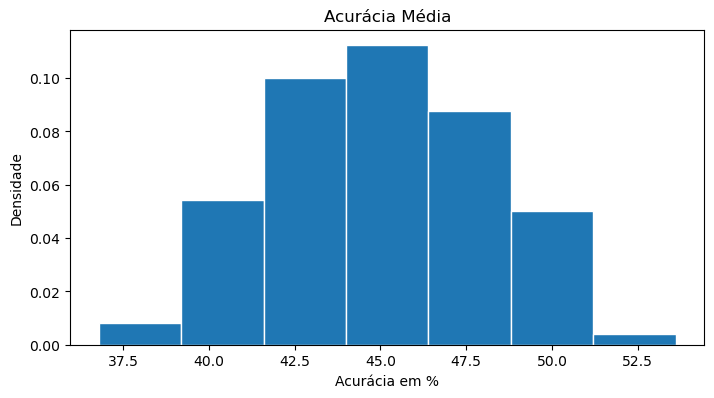

In [46]:
plt.figure(figsize=(18, 9))

plt.subplot(221) 
plt.hist(series_accuracy, edgecolor='white', density=True, bins= 7)
plt.title("Acurácia Média")
plt.ylabel('Densidade')
plt.xlabel('Acurácia em %')
plt.show()

In [53]:
series_accuracy.describe()

count    100.000000
mean      44.812000
std        3.094449
min       36.800000
25%       42.800000
50%       44.400000
75%       46.800000
max       53.600000
dtype: float64

___
## Aperfeiçoamento:

Trabalhos que conseguirem pelo menos conceito B vão evoluir em conceito dependendo da quantidade de itens avançados:

* IMPLEMENTOU outras limpezas e transformações que não afetem a qualidade da informação contida nos tweets. Ex: stemming, lemmatization, stopwords [x]
* CONSIDEROU mais de duas categorias na variável Target e INCREMENTOU a quantidade de notícias, mantendo pelo menos 250 notícias por categoria (OBRIGATÓRIO PARA TRIOS, sem contar como item avançado) [x]
* Para Target com duas categorias: CRIOU pelo menos quatro categorias intermediárias de relevância baseadas na probabilidade: ex.: muito relevante, relevante, neutro, irrelevante, muito irrelevante [x]
* EXPLICOU porquê não pode usar o próprio classificador para gerar mais amostras de treinamento [x]
* PROPÔS diferentes cenários para Naïve Bayes fora do contexto do projeto (pelo menos dois cenários, exceto aqueles já apresentados em sala pelos professores: por exemplo, filtro de spam) [x]
* SUGERIU e EXPLICOU melhorias reais com indicações concretas de como implementar (indicar como fazer e indicar material de pesquisa) [x]
* FEZ o item Qualidade do Classificador a partir de novas separações das Notícias entre Treinamento e Teste descrito no enunciado do projeto (OBRIGATÓRIO para conceitos A ou A+) [x]

___
## Referências

[Naive Bayes and Text Classification](https://arxiv.org/pdf/1410.5329.pdf)  **Mais completo**

[A practical explanation of a Naive Bayes Classifier](https://monkeylearn.com/blog/practical-explanation-naive-bayes-classifier/) **Mais simples**

https://blog.somostera.com/data-science/naive-bayes 

https://blog.somostera.com/data-science/naive-bayes

https://medium.com/blog-do-zouza/o-dilema-dos-dados-enfrentando-a-entropia-do-crescimento-de-dados-f727cdcb6be1